## Notebook demostrating MCMC Bayes inference for strain estimation in Laue analysis

### Requires the pymc2 library

In [37]:
##Import libraries
import numpy as np
import os
#from lauetoolsnn.utils_lauenn import resource_path
#base_lib_path = resource_path('')
#print("LaueNN base path" , resource_path(''))
#import json
### Load the json of material and extinctions
#with open(os.path.join(base_lib_path, 'lauetools/material.json'),'r') as f:
#    dict_Materials = json.load(f)
### Modify the dictionary values to add new entries
#dict_Materials["Cu_test"] = ["Cu_test", [5, 5, 5, 90, 90, 90], "fcc"]
#dict_Materials["Cu_test_strain"] = ["Cu_test_strain", [5., 5.02, 4.98, 90.0+np.random.rand(), 90.0-np.random.rand(), 90.0-np.random.rand()], "fcc"]
### dump the json back with new values
#with open(os.path.join(base_lib_path, 'lauetools/material.json'), 'w') as fp:
#    json.dump(dict_Materials, fp)    
    
from Laue_strain_funcs import getProximity, error_function_on_demand_strain, strain_estimator
from matplotlib import pyplot as plt
from mcmc_sampler import MCMCSampler
import lauetoolsnn.lauetools.CrystalParameters as CP
import lauetoolsnn.lauetools.lauecore as LT
import lauetoolsnn.lauetools.dict_LaueTools as dictLT

## Step 1 create a fake experimental Laue pattern

In [38]:
mat_exp = "Cu_test_strain" ## No longer cubic
mat_sim = "Cu_test"  ## reference is Cubic

## Lets create a fake strained Experimental laue pattern with Cu_test_strain material
detectorparameters = [79.5, 950, 950, 0.342, 0.482]
pixelsize = 0.0734

######################### FAKE EXPERIMENTAL PATTERN with Strain  ######################################
UBmatrix_exp = np.eye(3)
grain = CP.Prepare_Grain(mat_exp, UBmatrix_exp)
s_tth, s_chi, Miller_ind_exp, exp_posx, exp_posy, _ = LT.SimulateLaue_full_np(grain, 5, 22,
                                                                                detectorparameters,
                                                                                pixelsize=pixelsize,
                                                                                dim=(2018,2016),
                                                                                detectordiameter=pixelsize*2018*1.3,
                                                                                removeharmonics=1)

######################### SIMULATED PATTERN  ######################################
UBmatrix = np.eye(3)
grain = CP.Prepare_Grain(mat_sim, UBmatrix)
Twicetheta, Chi, Miller_ind, s_posx, s_posy, s_E = LT.SimulateLaue_full_np(grain, 5, 22,
                                                                            detectorparameters,
                                                                            pixelsize=pixelsize,
                                                                            dim=(2018,2016),
                                                                            detectordiameter=pixelsize*2018*1.3,
                                                                            removeharmonics=1)

## test if new material is added or not
UBmatrix = np.round(UBmatrix,4)
print(dictLT.dict_Materials["Cu_test_strain"])
print("UBmatrix of fake strained exp laue pattern is:", UBmatrix_exp[:,0], UBmatrix_exp[:,1], UBmatrix_exp[:,2])
print(dictLT.dict_Materials["Cu_test"])
print("UBmatrix of reference laue pattern is:", UBmatrix[:,0], UBmatrix[:,1], UBmatrix[:,2])
print()
print("We will start with the non strained Cu as initial (reference) material, it should be changed to match the values of Fake Exp Laue patterns, which has some strain")



['Cu_test_strain', [5.0, 5.02, 4.98, 90.99374188913973, 89.67754602824293, 89.05312174267368], 'fcc']
UBmatrix of fake strained exp laue pattern is: [1. 0. 0.] [0. 1. 0.] [0. 0. 1.]
['Cu_test', [5, 5, 5, 90, 90, 90], 'fcc']
UBmatrix of reference laue pattern is: [1. 0. 0.] [0. 1. 0.] [0. 0. 1.]

We will start with the non strained Cu as initial (reference) material, it should be changed to match the values of Fake Exp Laue patterns, which has some strain


In [39]:
### print how far both laue patterns are from each other in angle and pixel space
print("Exp", "Sim")
print(exp_posx[0], s_posx[0])
print(exp_posy[0], s_posy[0])
print(Miller_ind_exp[0], Miller_ind[0])
print("spots in Fake Exp Strained data", len(exp_posx))
print("spots in Sim data", len(s_posx))

Exp Sim
2013.5974734109557 2040.9533820086704
410.58689800245133 409.499614321252
[-4 -2  2] [-4 -2  2]
spots in Fake Exp Strained data 116
spots in Sim data 119


## Lets create a MCMC pipeline for fitting the data
### Firstly, we will use Least square optimization to get initial guess for MCMC
### So that the starting UB matrix and residues are good for MCMC to avoid more computation
### With MCMC we will try to fit each spots pixel deviation, while with Least Square we only calculate the Mean pixel

In [40]:
from scipy.optimize import leastsq

## best guess UB matrix
UBmat = UBmatrix
## reference pattern
lattice_params_sim = dictLT.dict_Materials[mat_sim][1]
B0matrix = CP.calc_B_RR(lattice_params_sim)
print("old UB is", UBmat)

for angtol in [0.5,0.4,0.3,0.2,0.1]:
    ######################### SIMULATED PATTERN  ######################################
    grain = CP.Prepare_Grain(mat_sim, UBmat)
    Twicetheta, Chi, Miller_ind, _, _, _ = LT.SimulateLaue_full_np(grain, 5, 22,
                                                                    detectorparameters,
                                                                    pixelsize=pixelsize,
                                                                    dim=(2018,2016),
                                                                    detectordiameter=pixelsize*2018*1.3,
                                                                    removeharmonics=1)
    
    ## get proximity for exp and theo spots
    linkedspots_link, linkExpMiller_link = getProximity(np.array([Twicetheta, Chi]),  # warning array(2theta, chi) ## Simulated
                                                        s_tth/2.0, s_chi, # warning theta, chi for exp
                                                        Miller_ind, angtol=angtol)
    print("number of linked spots is", len(linkedspots_link))
    if len(linkedspots_link) < 8:
        print("Not enough spots to use strain fitting")
    else:
        arraycouples = np.array(linkedspots_link)
        exp_indices = np.array(arraycouples[:, 0], dtype=np.int)
        sim_indices = np.array(arraycouples[:, 1], dtype=np.int)

        nb_pairs = len(exp_indices)
        Data_Q = np.array(linkExpMiller_link)[:, 1:]
        sim_indices = np.arange(nb_pairs)  # for fitting function this must be an arange...

        pixX = np.take(exp_posx, exp_indices)
        pixY = np.take(exp_posy, exp_indices)

        starting_orientmatrix = np.copy(UBmat)
        # ----------------------------------
        #  refinement model
        # ----------------------------------
        # -------------------------------------------------------
        # strain & orient
        initial_values = np.array([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

        residues, deltamat, newmatrix = error_function_on_demand_strain(
                                                                        initial_values,
                                                                        Data_Q,
                                                                        sim_indices,
                                                                        pixX,
                                                                        pixY,
                                                                        initrot=starting_orientmatrix,
                                                                        Bmat=B0matrix,
                                                                        verbose=1,
                                                                        detectorparameters = detectorparameters,
                                                                        pixelsize=pixelsize,
                                                                        weights=None,
                                                                        kf_direction='Z>0')
        init_mean_residues = np.copy(np.mean(residues))

        # setting  keywords of error_function_on_demand_strain during the fitting because leastsq handle only *args but not **kwds
        error_function_on_demand_strain.__defaults__ = (starting_orientmatrix,
                                                        B0matrix,
                                                        0,
                                                        detectorparameters,
                                                        pixelsize,
                                                        None,
                                                        'Z>0')
        # LEASTSQUARE
        res = leastsq(error_function_on_demand_strain,
                        initial_values,
                        args=(Data_Q, sim_indices, pixX, pixY),
                        maxfev=5000,
                        full_output=1,
                        xtol=1.0e-11,
                        epsfcn=0.0)
        strain_sol = res[0]
        if res[-1] not in (1, 2, 3, 4, 5):
            results = None
            print("Results are None, no strain refinement done")
        else:
            results = strain_sol
        lattice_part = results[:5]
        orient_part = results[5:]
        residues, deltamat, newmatrix = error_function_on_demand_strain(
                                                                        results,
                                                                        Data_Q,
                                                                        sim_indices,
                                                                        pixX,
                                                                        pixY,
                                                                        initrot=starting_orientmatrix,
                                                                        Bmat=B0matrix,
                                                                        verbose=1,
                                                                        detectorparameters = detectorparameters,
                                                                        pixelsize=pixelsize,
                                                                        weights=None,
                                                                        kf_direction='Z>0')
        final_residues = np.copy(np.mean(residues))
        UBmat = np.copy(newmatrix) 
        # ---------------------------------------------------------------
        # postprocessing of unit cell orientation and strain refinement
        # ---------------------------------------------------------------

        (devstrain, _) = CP.compute_deviatoricstrain(UBmat, B0matrix, lattice_params_sim)
        # overwrite and rescale possibly lattice lengthes
        constantlength = "a"
        lattice_parameter_direct_strain = CP.computeLatticeParameters_from_UB(UBmat, mat_sim, constantlength, dictmaterials=dictLT.dict_Materials)
        deviatoricstrain_sampleframe = CP.strain_from_crystal_to_sample_frame2(devstrain, UBmat)
        # in % already
        devstrain = np.round(devstrain * 100, decimals=3)
        deviatoricstrain_sampleframe = np.round(deviatoricstrain_sampleframe * 100, decimals=3)
        print("Lattice values from Least square (without scaling)", lattice_part)
        print("Orientation values from Least square", orient_part)
        print("Deviatoric Strain (%)", devstrain[0,:], devstrain[1,:], devstrain[2,:])
        print("Reference Lattice", dictLT.dict_Materials["Cu_test"][1])
        print("Expected Lattice distortion", np.round(dictLT.dict_Materials["Cu_test_strain"][1],4))
        print("Strain refined Lattice from reference", np.round(lattice_parameter_direct_strain,4))
        print("Initial residues", init_mean_residues)
        print("Final residues", final_residues)
        print("new UB is", UBmat)

old UB is [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
number of linked spots is 53
Lattice values from Least square (without scaling) [ 0.996012197498092  1.003861169511649 -0.016561795069061
 -0.005939877927654  0.017412795494889]
Orientation values from Least square [ 3.627340023731223e-06 -1.293404250770345e-06 -3.833737924674355e-07]
Deviatoric Strain (%) [0.143 0.83  0.28 ] [ 0.83   0.53  -0.869] [ 0.28  -0.869 -0.673]
Reference Lattice [5, 5, 5, 90, 90, 90]
Expected Lattice distortion [ 5.      5.02    4.98   90.9937 89.6775 89.0531]
Strain refined Lattice from reference [ 5.      5.02    4.98   90.9937 89.6776 89.0531]
Initial residues 17.91327452944075
Final residues 1.8260018646927763e-05
new UB is [[ 9.999999999999980e-01 -1.656178840460944e-02 -5.939814257669407e-03]
 [-6.691133515265906e-09  9.960121976089088e-01  1.741277287330767e-02]
 [-6.330902650347903e-08  2.353265255557128e-08  1.003861170280774e+00]]
number of linked spots is 116
Lattice values from Least square (without s

1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0
Difference between experiment and simulated peaks is  -0.0007467243171390692


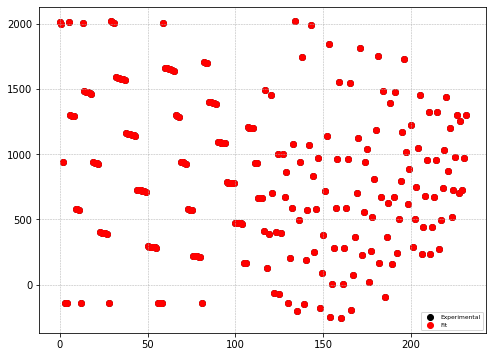

In [41]:
##verify least square results
ang_tol = 0.01
model = strain_estimator(mat_sim, detectorparameters, 
                         pixelsize, UBmat, ang_tol, 
                         s_tth, s_chi, exp_posx, exp_posy, B0matrix)

sim_set, exp_set = model.strain_simulator(results[0],results[1],results[2],results[3],results[4],results[5],results[6],results[7])
print("Difference between experiment and simulated peaks is ", np.sum(sim_set-exp_set))
fig = plt.figure(1,figsize=(8,6))
plt.scatter(range(len(exp_set)),exp_set, color='k',label = r'Experimental')
plt.scatter(range(len(sim_set)),sim_set, color='r',label = r'Fit')
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(loc=4,prop={'size':6})
plt.show()

## MCMC part

In [42]:
# from least squares as initial guess
b,c,alpha,beta,gamma = lattice_part
orx, ory, orz = orient_part
lsquare_ang_tol = 0.1
initrot = UBmat
# =============================================================================
# Define prior distributions
# =============================================================================
var = 0.3
var_ori = 0.3
b_min, b_max = b-var, b+var
c_min, c_max = c-var, c+var
alp_min, alp_max = alpha-var, alpha+var
bet_min, bet_max = beta-var, beta+var
gam_min, gam_max = gamma-var, gamma+var
orientx_min, orientx_max = orx-var_ori, orx+var_ori
orienty_min, orienty_max = ory-var_ori, ory+var_ori
orientz_min, orientz_max = orz-var_ori, orz+var_ori

param_priors = {
                'b':  ['Uniform', b_min, b_max],
                'c':  ['Uniform', c_min, c_max],
                'alpha':  ['Uniform', alp_min, alp_max],
                'beta':  ['Uniform', bet_min, bet_max],
                'gamma':  ['Uniform', gam_min, gam_max],
                'angx':  ['Uniform', orientx_min, orientx_max],
                'angy':  ['Uniform', orienty_min, orienty_max],
                'angz':  ['Uniform', orientz_min, orientz_max]
                }

initial_guess = {'b': b,'c': c, 
                 'alpha':alpha, 'beta':beta, 'gamma':gamma,
                'angx':orx, 'angy':ory, 'angz':orz}
keys = ['b', 'c', 'alpha', 'beta', 'gamma', 'angx', 'angy', 'angz']

#initial_guess = None
# =============================================================================
# Initialize model and load data
# =============================================================================
model = strain_estimator(mat_sim, detectorparameters, 
                         pixelsize, UBmat, lsquare_ang_tol, 
                         s_tth, s_chi, exp_posx, exp_posy, B0matrix)

# =============================================================================
# EXPERIMENTAL PARAMETERS INITIALIZATION
# =============================================================================
# Pixel positions of peaks with their Gaussian fitting standard deviation
exp_set = model.expXY
exp_tol = 0.1 ##pixel uncertainity or Gaussian widths in pixel
#%% =============================================================================
num_samples = 10000
num_samples_burnin = 5000
mcmc = MCMCSampler(exp_set, model, param_priors)
mcmc.generate_pymc_model(q0=initial_guess, std_dev0=exp_tol)
mcmc.sample(num_samples, num_samples_burnin, step_method='metropolis', \
            tune_throughout = False, scales = None, burn_till_tuned = False, 
            proposal_distribution='normal',verbose=0)
##print the mean values
trace = mcmc.MCMC.trace
print()
for key in keys:
    print(np.mean(trace(key)[:]))
    print(np.median(trace(key)[:]))

additon order: gamma
additon order: c
additon order: beta
additon order: b
additon order: angz
additon order: angy
additon order: angx
additon order: alpha
 [-----------------100%-----------------] 10000 of 10000 complete in 310.0 sec
1.000011377734636
1.0000195426421987
0.9999878722589789
0.9999948735139912
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


Lattice values from Least square (without scaling) [1. 1. 0. 0. 0.]
Orientation values from Least square [0. 0. 0.]
Deviatoric Strain (%) [0.194 0.829 0.28 ] [ 0.829  0.469 -0.868] [ 0.28  -0.868 -0.662]
Reference Lattice [5, 5, 5, 90, 90, 90]
Expected Lattice distortion [ 5.      5.02    4.98   90.9937 89.6775 89.0531]
Strain refined Lattice from reference [ 5.      5.0145  4.978  90.9937 89.6775 89.0531]
Initial residues 3.0293305870435347e-05
Final residues 0.8045707599002928
1.0000195426421987 0.9999948735139912 0.0 0.0 0.0 0.0 0.0 0.0
Difference between experiment and simulated peaks is  -0.07260926191344197


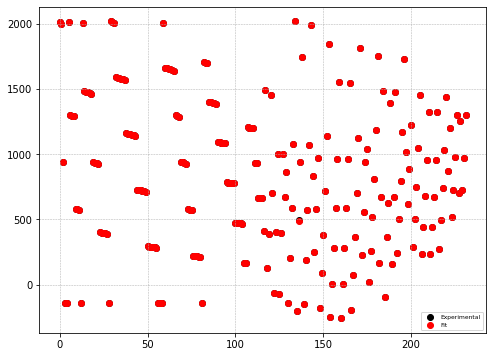

In [46]:
### LOAD THE PICKLE OBJECT
import pymc
from scipy.stats import gaussian_kde
from tqdm import trange
db = pymc.database.pickle.load("mcmc.p")    
trace = db.trace

b = trace(keys[0])[:]
c = trace(keys[1])[:]
alpha = trace(keys[2])[:]  
beta = trace(keys[3])[:]
gamma = trace(keys[4])[:]
rotx = trace(keys[5])[:]
roty = trace(keys[6])[:]
rotz = trace(keys[7])[:]


residues, deltamat, newmatrix = error_function_on_demand_strain(
                                                                [np.max(b), np.max(c), np.max(alpha), 
                                                                 np.max(beta), np.max(gamma), 
                                                                 np.max(rotx), np.max(roty), np.max(rotz)],
                                                                Data_Q,
                                                                sim_indices,
                                                                pixX,
                                                                pixY,
                                                                initrot=starting_orientmatrix,
                                                                Bmat=B0matrix,
                                                                verbose=1,
                                                                pixelsize=pixelsize,
                                                                weights=None,
                                                                kf_direction='Z>0')
final_residues = np.copy(np.mean(residues))
UBmat = np.copy(newmatrix) 
# ---------------------------------------------------------------
# postprocessing of unit cell orientation and strain refinement
# ---------------------------------------------------------------

(devstrain, _) = CP.compute_deviatoricstrain(UBmat, B0matrix, lattice_params_sim)
# overwrite and rescale possibly lattice lengthes
constantlength = "a"
lattice_parameter_direct_strain = CP.computeLatticeParameters_from_UB(UBmat, mat_sim, constantlength, dictmaterials=dictLT.dict_Materials)
# in % already
devstrain = np.round(devstrain * 100, decimals=3)
print("Lattice values from Least square (without scaling)", lattice_part)
print("Orientation values from Least square", orient_part)
print("Deviatoric Strain (%)", devstrain[0,:], devstrain[1,:], devstrain[2,:])
print("Reference Lattice", dictLT.dict_Materials["Cu_test"][1])
print("Expected Lattice distortion", np.round(dictLT.dict_Materials["Cu_test_strain"][1],4))
print("Strain refined Lattice from reference", np.round(lattice_parameter_direct_strain,4))
print("Initial residues", init_mean_residues)
print("Final residues", final_residues)

##rescale lattice params
act_lattice = []
act_residues = []
for ii in range(len(b)):
    residues, deltamat, newmatrix = error_function_on_demand_strain(
                                                                [b[ii], c[ii], alpha[ii], 
                                                                 beta[ii], gamma[ii], 
                                                                 rotx[ii], roty[ii], rotz[ii]],
                                                                Data_Q,
                                                                sim_indices,
                                                                pixX,
                                                                pixY,
                                                                initrot=starting_orientmatrix,
                                                                Bmat=B0matrix,
                                                                verbose=1,
                                                                pixelsize=pixelsize,
                                                                weights=None,
                                                                kf_direction='Z>0')
    act_residues.append(np.mean(residues))
    constantlength = "a"
    lattice_parameter_direct_strain = CP.computeLatticeParameters_from_UB(newmatrix, mat_sim, constantlength, dictmaterials=dictLT.dict_Materials)
    act_lattice.append(lattice_parameter_direct_strain)
act_lattice = np.array(act_lattice)


## FINAL PLOT
### LOAD THE PICKLE OBJECT
sim_set, exp_set = model.strain_simulator(np.median(b),
                               np.median(c),
                               np.median(alpha),
                               np.median(beta),
                               np.median(gamma), 
                               np.median(rotx), 
                               np.median(roty), 
                               np.median(rotz))
print("Difference between experiment and simulated peaks is ", np.sum(sim_set-exp_set))

fig = plt.figure(1,figsize=(8,6))
plt.scatter(range(len(exp_set)),exp_set, color='k',label = r'Experimental')
plt.scatter(range(len(sim_set)),sim_set, color='r',label = r'Fit')
plt.grid(linestyle='--', linewidth=0.5)
plt.legend(loc=4,prop={'size':6})
plt.show()
#plt.savefig('Exp_data_rangesim.png', bbox_inches='tight',format='png', dpi=1000) 
#plt.close(fig)



(array([  3.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   3.,   1.,   0.,   0.,   1.,  11.,   2.,  16.,
         10.,   7.,  11.,  17.,   9.,  31.,   4.,  25.,   5.,  36.,  26.,
         38.,  87., 103.,  97.,  94.,  66., 114.,  51.,  53., 121., 111.,
         85., 115., 139., 150., 120., 123., 222., 164.,  94., 206., 139.,
        178., 167., 194., 100., 102.,  94.,  96., 116., 149.,  60., 114.,
         90.,  49.,  74.,  55.,  63.,  81.,  70.,  56.,  56.,  27.,  62.,
         28.,  37.,  19.,  25.,   4.,  13.,   8.,  22.,  22.,   5.,  11.,
          0.,  12.,   0.,   0.,   2.,   0.,   1.,  15.,   4.,   0.,   4.,
          2.]),
 array([5.014453113560527, 5.014554791113387, 5.014656468666247,
        5.014758146219107, 5.014859823771967, 5.014961501324826,
        5.015063178877686, 5.015164856430546, 5.015266533983405,
        5.015368211536265, 5.015469889089125, 5.015571566641985,
        5.015673244194845, 5.015774921747705, 5.0158765993

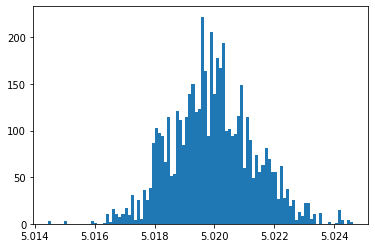

In [51]:
## Scaled lattice parameters distribution
plt.hist(act_lattice[:,1], bins=100)